### Part 0: Importing constants and libraries.

Here we are just importing the needed libraries, setting up the constants needed either for the functions to work (sign, zooms) or the calculation/conversions to be done (XCELL, ZCELL, global_shifts, local_shifts).

The ```MAX_ANGLE_DIFF``` and ```MAX_ANGLE_LOC_GLOB``` constants are part of the selection strategy; they will be explained in the next sections.

Pandas, Numpy, Matplotlib are used to create DataFrames, arrays and plotting.
Itertools is used to calculate cartesian products and combinations.
Os is used to access the directories and not singular files (so we can read all the txt files in the physics runs).
Time was used to detect the bottlenecks in the code, so that only the fitting functions actually matter.

In [2]:
#SETUP with Libraries and Constants

import pandas as pd
import numpy as np
import matplotlib.axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import product
from itertools import combinations as comb
import os
import time

# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = np.array([994.2, 947.4,-267.4,-261.5,])

# Z coordinates translations
local_z_shifts = np.array([z*ZCELL for z  in range(0,4)])
global_z_shifts = np.array([823.5, 0, 823.5, 0])

#Define Zooms for the plotting function
zooms = {0:((280, 1000), (775, 925)), 
         1:((235, 960), (-50, 100)),
         2:((-1000, -250), (775, 925)),
         3:((-1000, -250), (-50, 100)),
         4:((-1000, 1000), (-100, 1000))}

signs = {(0,1): 1,
         (2,3): -1}

In [1]:
print([z*13 for z in range(0, 4)])

[0, 13, 26, 39]


In [3]:
# This is core part of the selection strategy to identify which good trajectories are actually muons and which are not.
# The thresholds were found via making the fit function return the angles for several plausible trajectories, then selecting
# the couple that had consistent beams of muons AND caught the example given in the Project.ipynb.
# Note that these are only hypothetical thresholds: there is no guarantees they correctly identify ALL the muons and exclude ALL the noise.

# Max deflection of the two local fits in degrees (360°)
MAX_ANGLE_DIFF = 5

# Max deflection between local and global fit in degrees (360°)
MAX_ANGLE_LOC_GLOB = 2

### Part 1: Loading and Plotting data

Here we define the ```load_data``` function to collect the data from the various txt files inside ```data/Run000XXX```. The ```event_plot``` is also defined, among other useful function, such as coordinate conversion and the drawing of the big rectangles.

In [4]:
def load_data(path: str, output: bool = False) -> list:

    # The output flag is needed to specify if the reading is done on input file (originals), which have a format of 2 | (5 * N) columns
    # or the output files (produced by the fits), which have a format of 2 | (4 * N) columns.
    
    # Already know in advance the column names, which are repeated each 5.
    column_names = ["chamber", "layer", "x_left", "x_right", "time"]
    data = []

    # For each file path in the directory path.
    for file_path in os.listdir(path):

        # Open the actual file that has path: dir_path+file_path, read it.
        with open(os.path.join(path, file_path), 'r+') as file:
            body = file.readlines()

        # Read all the lines in the body, just append to the data itself.
        for line in body:
            info = line.replace("\n", "").split(" ")
            if output:
                hits = [info[4*i+2:4*i+6] for i in range(int(info[1]))]
                event = pd.DataFrame(hits, columns = column_names[:-1], dtype=float).astype({"chamber":"int", "layer":"int"})
            else:
                hits = [info[5*i+2:5*i+7] for i in range(int(info[1]))]
                event = pd.DataFrame(hits, columns = column_names, dtype=float).astype({"chamber":"int", "layer":"int"}).drop(labels="time", axis=1)
            data.append(event)

    return data


In [5]:
# Specify the FOLDER to get the txt files from.
path = "data/Run000331"

# Physics runs start with 0003. This requirement may change depending on future naming rules.
physics_run = False
if "0003" in path: physics_run = True

data_read = load_data(path)
example_event = data_read[892]
print(f"Read a total of {len(data_read)} events.")

Read a total of 34428 events.


In [6]:
example_event

,chamber,layer,x_left,x_right
0,0,4,585.80,590.20
1,0,1,551.60,582.40
2,0,3,550.00,584.00
3,1,2,580.30,595.70
4,1,4,582.50,593.50
5,1,1,554.10,579.90
6,1,3,553.40,580.60
7,2,1,60.32,65.68
8,2,3,59.61,66.39
9,2,2,24.56,59.44


In [6]:
def coords_conv(event: pd.DataFrame) -> pd.DataFrame:
    """
    Returns global points in the xz plane from local coordinates, where the points returned
    are in the format (x,z), always given as left_point, right_point.

    It uses global/local transformation given in the Project guide.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---    
    
    Output:

    `event`: pandas.Dataframe
        the original even with added column x_global_left, x_global_right, z_global

    """

    chamber = event["chamber"]
    layer = event["layer"]-1
    x_left, x_right = event["x_left"], event["x_right"]

    x_left_prime = global_x_shifts[chamber] - x_left
    x_right_prime = global_x_shifts[chamber] - x_right

    z = global_z_shifts[chamber] + 3*ZCELL - local_z_shifts[layer]

    event["x_global_left"] = x_left_prime
    event["x_global_right"] = x_right_prime
    event["z_global"] = z

    return event




def cells_conv(event: pd.DataFrame) -> np.ndarray:
    """
    Returns the cells centers given the event with several hits, one center per hit. The centers are already in global coordinates, 
    account for the alternating pattern between layers in the detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---

    Output:

    `center_points`: numpy.ndarray, shape:(N, 2)
        An ndarray containing the center of the cells in the format [x, z]. 
        Note the shape (N, 2) in order to iterate through the different N centers.
    
    """
    centers = (event["x_left"] + event["x_right"])/2

    chamber = event["chamber"]
    layer = event["layer"] - 1

    x_centers = global_x_shifts[chamber] - centers
    z = global_z_shifts[chamber] + 3*ZCELL - local_z_shifts[layer]

    center_points = np.stack([x_centers, z]).T

    return center_points


In [7]:
def draw_big_rectangles(ax: matplotlib.axes.Axes):
    
    rects = [patches.Rectangle((x-16.5*XCELL, z-ZCELL*0.5), 
                            16.5*XCELL, 4*ZCELL, 
                            linewidth=1, edgecolor='darkgray', facecolor='none', zorder=0) for x,z in zip(global_x_shifts, global_z_shifts)]
    
    for rect in rects: ax.add_patch(rect)

In [ ]:
def event_plot( event: pd.DataFrame, ax: matplotlib.axes.Axes, detector: int = 4, zoom: bool = False) -> pd.DataFrame:

    if len(event)==0: return event

    #Use custom values for detectors zoom / xlim zoom, in case provided.
    if detector not in [0,1,2,3]: detector=4
    xlim, ylim = zooms[detector]


    #Calculate points of hit in global coordinates
    event = coords_conv(event)
    if zoom and detector !=4: 
        xlim = (event[event["chamber"]==detector]["x_global_left"].min() - 50, 
                event[event["chamber"]==detector]["x_global_right"].max() + 50)

    #Set the limits for the ax to plot the picture
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    #Create small gray rectangles (cells)
    #For each point, find the nearest center in global coords (format: x_center, z_center, layer) and plot according to alternate pattern
    centers = cells_conv(event)
    small_rects = [patches.Rectangle((center[0]-0.5*XCELL, center[1]-0.5*ZCELL), 
                                     XCELL, ZCELL, 
                                     linewidth=1, edgecolor="darkgray", facecolor="none", zorder=7) for center in centers]
    for rect in small_rects: ax.add_patch(rect)


    #Plot blue-red points
    ax.plot(event["x_global_left"], event["z_global"], ".r", zorder=8)
    ax.plot(event["x_global_right"], event["z_global"], '.b', zorder=8)
    

    #Set title and labels
    if detector != 4: ax.set_title(f"Detector {detector}")
    else: ax.set_title(f"View of all detectors")
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")

    plt.plot()

    return event

In [8]:
def event_plot(event: pd.DataFrame, ax: matplotlib.axes.Axes, detector: int = 4, zoom: bool = False) -> pd.DataFrame:
    """
    Plots the table of hits (event) on the given ax, marking the hit points and the corresponding triggered cells.
    If zoom is specified, the graph is zoomed on the corresponding detector [0->3], otherwise defaults to the larger picture.
    If an xlim is specified, it can be horizontally zoomed, otherwise the plot gets the xlim from the default constants for each detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above.
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    `ax`: matplotlib.axes.Axes
        The ax on which to plot the objects.

    `detector`: int, optional
        The detector on which to zoom on [0, 1, 2, 3]. If value is not legal, it defaults to 4.

    `zoom`: bool, optional
        Automatic zooming on the interesting portion (the one with actual hits) of the detector. If False, the entire chamber is plotted.
     
    ---

    Output:

    `event_modified` as `event`: pandas.DataFrame
        Input event but with x_left, z_left and x_right, z_right added in global coordinates. Accessible with the same name 
        in the column, as in format: chamber | layer | x_left | x_right | x_global_left | x_global_right | z_global

    `ax`: matplotlib.axes.Axes
        Same input ax, to plot on the fits.

    """
    if len(event)==0: return event

    #Use custom values for detectors zoom / xlim zoom, in case provided.
    if detector not in [0,1,2,3]: detector=4
    xlim, ylim = zooms[detector]


    #Calculate points of hit in global coordinates
    event = coords_conv(event)
    if zoom and detector !=4: 
        xlim = (event[event["chamber"]==detector]["x_global_left"].min() - 50, 
                event[event["chamber"]==detector]["x_global_right"].max() + 50)

    #Set the limits for the ax to plot the picture
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    #Create small gray rectangles (cells)
    #For each point, find the nearest center in global coords (format: x_center, z_center, layer) and plot according to alternate pattern
    centers = cells_conv(event)
    small_rects = [patches.Rectangle((center[0]-0.5*XCELL, center[1]-0.5*ZCELL), 
                                     XCELL, ZCELL, 
                                     linewidth=1, edgecolor="darkgray", facecolor="none", zorder=7) for center in centers]
    for rect in small_rects: ax.add_patch(rect)


    #Plot blue-red points
    ax.plot(event["x_global_left"], event["z_global"], ".r", zorder=8)
    ax.plot(event["x_global_right"], event["z_global"], '.b', zorder=8)
    

    #Set title and labels
    if detector != 4: ax.set_title(f"Detector {detector}")
    else: ax.set_title(f"View of all detectors")
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")

    plt.plot()

    return event

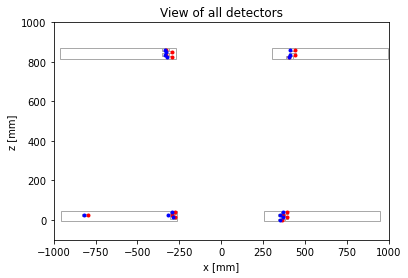

In [9]:
# Create the fig and ax to plot on. Draw the big rectangles (detectors) once at the start.

fig, ax = plt.subplots()
draw_big_rectangles(ax)
example_event = event_plot(example_event, ax, 4)

### Part 2 and 3: Fitting function

This is the fitting function, the core of the project.
Based on an event and a couple of detectors, it calculates all the possible 3-point tuples across 3-different layers (these are sure to exist as we filter the data in the next section), and through a selection strategy determines if the minimal residual fit is considerable a muon or not.

The selection strategy is based on angles. Assuming we find two good trajectories in the detectors of the aforementioned couple, we have a maximum threshold for the difference in angles between them (i.e. the muons cannot possibly accelerate centripetally too much) and a maximum threshold for the difference in angles between the global fit and the local fit (so that even if the local fits are parallel, if they are too distant from each other it means at least one of them is just noise).

The thresholds were found by analysing all the best trajectories, lowering them so that we get a dense "muon beam" on each side of the detectors (and possibly a few deviating trajectories, which could still be valid muons). We also made sure to incorporate the example given in the Project.ipynb, meaning that our strategy could detect it.

In [10]:
def fits(event: pd.DataFrame, ax: matplotlib.axes.Axes, couple: tuple = (2,3), global_flag: bool = True) -> int:
    """
    Calculates all the possible local fits on 3 points, across different layers, in two detectors explicitly stated by the couple parameter,
    then it calculates the global fit. The good fits are decided upon special conditions (logical, angular, spatial), stated afterwards.
    It returns whether a good fit has been found (1) or not (0).
    The global fit is optionally plotted (default True) following the global_flag parameter.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above.
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    `ax`: matplotlib.axes.Axes
        The ax on which to plot the objects.

    `couple`: tuple[int, int], optional
        The detectors couple on which to make the fits. Default is (2,3) for convenience.

    `global_flag`: bool, optional
        Flag to decide whether to plot the global fit (black lines). By default it is True, only use False when testing/analyzing.
     
    ---

    Output:

    `int`: int
        0 or 1, depending on the validity of the fit. 1 meaning a valid muon has been found, 0 if not.
        This only refers to the couple analyzed.

    """

    # if len(event)==0: return 0
    sign = signs[couple]
    chambers = couple

    # Create useful containers for the local fits, for the points of these local fits, for the angle formed with the z-axis, and linspace for plotting.
    local_fits = {}
    good_local_points = []
    angles = []
    linspace = np.linspace(-1000, 1000, 10000)

    # Load every points for each layer in points -> a dictionary with layers as keys.
    for chamber in chambers:

        points = {}

        # Calculate unique values for layers -> Break if there are less than 3 points on 3 different layers
        layers = np.unique(event[event["chamber"]==chamber]["layer"])

        # Load the actual points for the layer in points{}
        for layer in layers:
            event_filtered = event[(event["chamber"]==chamber) & (event["layer"]==layer)]
            left_points = np.stack([event_filtered["x_global_left"], event_filtered["z_global"]]).T
            right_points = np.stack([event_filtered["x_global_right"], event_filtered["z_global"]]).T

            concat = np.concatenate([left_points, right_points])
            
            points[layer] = concat

        # Calculate all the combinations taking one point from each layer, comb(stuff, 3) just takes three layers out of 4.
        # Make a list of these combinations (i.e. [[1,2,3], [1,3,4], ...]), which are then unpacked in product to get
        # The cartesian product of all the points inside the layers. This is then transformed into a list, to get
        # A list of lists of tuples (p_i, p_j, p_k), where p_n are coming from the combination [i,j,k]
        # The lists are summed into one big list, finally containing all the possible 3-points tuple from 3 different layers.

        # Take all the point lists and put them into a big list
        point_lists = [points[key] for key in points.keys()]

        # Calculate the combinations of 3 lists of points (one list per layer) out of 4, then get the cartesian product of those
        # for each combination. Put the results of the cartesian products into a list.
        combinations_list = [list(product(*three_points_list_comb)) for three_points_list_comb in list(comb(point_lists, 3))]

        # Combine all the result into one big list, so that you have all the possible 3-points tuples across 3 different layers.
        # This basically flattens the combinations_list.
        combinations = sum(combinations_list, [])

        # Put them into a np array for use.
        combinations = np.array(combinations)
        
        # Calculate the first fit so that we have something to compare it to
        # IMPORTANT: Calculating with z-x and not x-z because of Vertical Square Minimizing in polyfit. This discourages vertical lines,
        # so we just swap x<->z, fit (now we get horizontal lines which are favoured), then plot again inverting x<->z again.
        best_coeffs, min_residual, _, _, _ = np.polyfit(combinations[0][:, 1], combinations[0][:, 0], 1, full=True)
        best_points = combinations[0]

        # Calculate all the local fits for every combination of points, find the one that best satisfied the conditions (logical, angular and spatial).
        for combination in combinations:
            temp_coeffs, residual, _, _, _ = np.polyfit(combination[:, 1], combination[:, 0], 1, full=True)
            angle = np.arctan(temp_coeffs[0])
            model = np.poly1d(temp_coeffs)

            # If residual is lowered, this means better fit. We have an angle requirement on the inverse-slope as well:
            logical_conditions = residual<min_residual

            if sign==-1: angular_conditions = angle<0 and angle>-np.pi/4
            else: angular_conditions = angle>0 and angle < np.pi/4

            # We project the fit towards the other corresponding detector, and check if it falls inside it.
            corresponding_x = model(global_z_shifts[chamber-1])
            spatial_conditions = corresponding_x > global_x_shifts[chamber]-16.5*XCELL and corresponding_x < global_x_shifts[chamber]

            # Only if all these conditions apply, we update the model with the new, better one.
            if logical_conditions and angular_conditions and spatial_conditions:
                min_residual = residual
                best_coeffs = temp_coeffs
                best_points = combination

        # We still need to calculate the same conditions as before, because we started with one model, then updated it ->
        # -> the first could still be bad. This could be bypassed with a flag that checks whether the model has been updated, but it's not strongly needed
        best_angle = np.arctan(best_coeffs[0])

        if sign==-1: angular_conditions = best_angle<0 and best_angle>-np.pi/4
        else: angular_conditions = best_angle>0 and best_angle < np.pi/4

        model = np.poly1d(best_coeffs)

        corresponding_x = model(global_z_shifts[chamber-1])
        spatial_conditions = corresponding_x > global_x_shifts[chamber]-16.5*XCELL and corresponding_x < global_x_shifts[chamber]

        # If model passes the checks, we save the model itself, the angle and the points. The angle will be needed to assess
        # The angular deviation of the path, the good points will be needed to calculate the global fit.
        if spatial_conditions and angular_conditions:
            best_fit = model
            local_fits[chamber] = best_fit
            angles.append(np.arctan(best_coeffs[0]))
            good_local_points.append(best_points)

    # We need 6 points to calculate the fit (3 coming from each detector, len=2).
    if len(good_local_points)!=2: return 0
    
    # Calculate the difference of the angles in degrees (because we are still in middle school).
    angle_diff = (angles[1]-angles[0])*360/(2*np.pi)
    
    # This is just a matter of concatenating the points and fit. I still invert the x<->z so that we can compare the angles
    good_local_points = np.concatenate(good_local_points)
    global_coeffs = np.polyfit(good_local_points[:, 1], good_local_points[:, 0], 1)
    global_fit = np.poly1d(global_coeffs)

    # If and only if the requirements for the models are met, those are plotted. Otherwise, return 0.
    global_angle = np.arctan(global_coeffs[0])
    loc_glob_angle1 = (global_angle - angles[0])*360/(2*np.pi)
    loc_glob_angle2 = (global_angle - angles[1])*360/(2*np.pi)

    angular_conditions = np.abs(angle_diff)<MAX_ANGLE_DIFF and max(np.abs(loc_glob_angle2), np.abs(loc_glob_angle1))<MAX_ANGLE_LOC_GLOB
    spatial_conditions = np.sign(global_coeffs[0])==sign

    if angular_conditions and spatial_conditions:
        
        for key in local_fits.keys():
            ax.plot(local_fits[key](linspace), linspace, '--c', zorder=9)
        if global_flag: ax.plot(global_fit(linspace), linspace, 'black', zorder=10)

        # Return a useful variable to understand the good limits/requirements.
        # EDIT: Now returns 1 if a valid global+local fit is found, otherwise 0. This counts the muons.
        return 1

    return 0


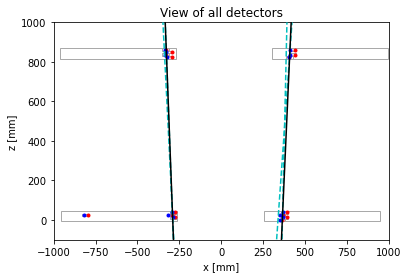

In [11]:
fig, ax = plt.subplots()
draw_big_rectangles(ax)

example_event = event_plot(example_event, ax, 4)
for couple in [(0,1), (2,3)]:
    _ = fits(example_event, ax, couple)

This is were the filtering (preselection) happens, and the functions are called on each event.
For the preselection, we made sure to have only events that had at least 3 points across 3 different layers in EACH detector.

This is to make sure that:
  - the local fits are always possible and not trivial (a local fit between two points obviously has 0 residual)
  - the trajectories could be interpreted as muons

Filtered Data. 327 valid events found.


KeyboardInterrupt: 

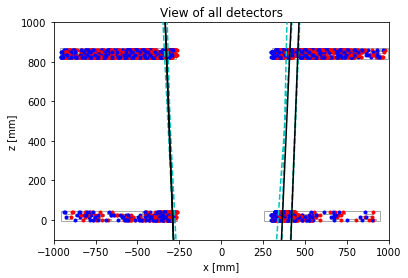

In [12]:
fig, ax = plt.subplots()
draw_big_rectangles(ax)

detectors_to_fit = (2,3)
data_filtered, data_final = [], []
n_muons = 0

data = data_read


# Physics runs and Calibration runs are different: the first requires hits on both couple of detectors, the second focuses on one couple only.
if physics_run:
    
    # Needs to have at least 3 hits on each detector, otherwise it's a useless event
    # Clean data to have only events with at least 3 hits on each detector in 3 different layers
    data_filtered = [event for event in data if all(x>2 for x in [len(np.unique(event[event["chamber"] == chamber]["layer"])) for chamber in [0,1,2,3]])]
    print(f"Filtered Data. {len(data_filtered)} valid events found.")

    detectors_to_fit = [(0,1), (2,3)]

#Filter data points and get only hits from the couple (2,3) or (0,1). Filter only events with 3 or more hits on both detectors in 3 different layers.
else:

    for event in data:
        single = event[(event["chamber"] == detectors_to_fit[0]) | (event["chamber"] == detectors_to_fit[1])]
        data_filtered.append(single)

    data_filtered = [event for event in data if all(x>2 for x in [len(np.unique(event[event["chamber"] == chamber]["layer"])) for chamber in detectors_to_fit])]
    print(f"Filtered Data. {len(data_filtered)} valid events found.")

    detectors_to_fit = [detectors_to_fit]

#Take single event from filtered ones
for event in data_filtered:

    event_modified = event_plot(event, ax, 4, zoom=True)

    found_muon = 1
    for couple in detectors_to_fit:
        found_muon *= fits(event_modified, ax, couple = couple, global_flag=True)

    n_muons += found_muon
    if found_muon:
        data_final.append(event)

print(f"{n_muons} muon couples have been found.")
plt.plot()

### Bonus Part: writing outputs

Here we write the good detected events in different files. Since the analysis was done manually, the same path/file to be written in is changed manually as well.

The format is slightly changed: since the time column was redundant, in the output file this was not written (the difference in ```output=True``` and ```output=False``` in ```load_data``` stems from this difference).

The information about the fits themselves is not saved: since we already know these are good events, calculating again local and global fits is not computationally expensive.

In [12]:
full = ""
i = 1
for element in data_final:
    line = f"{i} {len(element.index)}"
    for index, row in element.iterrows():
        string = f" {row['chamber']} {row['layer']} {row['x_left']} {row['x_right']}"
        line += string
    full += line + "\n"
    i+=1

with open("outputs/muons_in_332.txt", 'w') as file:
    file.write(full)